In [1]:
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 3. Adaptive methods
Adaptive methods use an adaptive per-parameter step size. Most of them are well suited for large scale stochastic optimization, i.e. training neural nets.

### 3.1 Adagrad
**Adagrad** divides the gradient by square root of sum of squares of past gradients, making step size for weights where gradients have been large smaller and vice versa. The update is:
$$
v_t \leftarrow v_{t-1} + \nabla f(x_t)^2
$$
$$
x_{t+1} \leftarrow x_t - \eta \frac{\nabla f(x_t)}{\sqrt{v_t + \epsilon}}
$$

Here $\eta$ is the step size, $v$ accumulates square gradients, and $\epsilon$ is a small scalar added to avoid division by 0.

This is actually the diagonal version of Adagrad, the full version and approximations to it are described later in this notebook.

Reference: *[Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. Journal of machine learning research, 12(7)](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)*

finished in 6.4s., reached loss = 0.00462                                      


<Axes: >

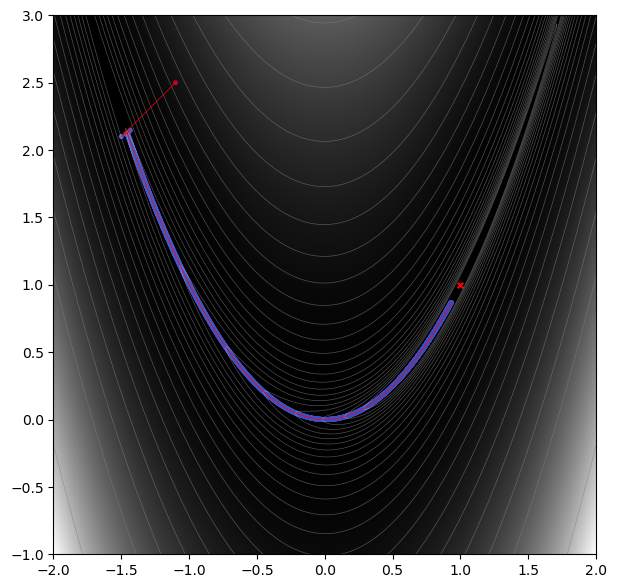

In [2]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.Adagrad(), tz.m.LR(4e-1))
func.run(optimizer, max_steps=5000)
func.plot(log_contour=True)

### 3.2 RMSprop
A drawback of Adagrad simple accumulation doesn't forget old gradients that might be no longer relevant. **RMSprop** solves this by replacing sum of squares of past gradients with an exponential moving average.

$$
v_t \leftarrow \beta v_{t-1} + (1 - \beta) \nabla f(x_t)^2
$$
$$
x_{t+1} \leftarrow x_t - \eta \frac{\nabla f(x_t)}{\sqrt{v_t + \epsilon}}
$$

Here $\beta$ is the *smoothing* hyperparameter that determines how fast old gradients are forgotten, default value is 0.99. If $\beta=0$, RMSprop becomes equivalent to SignGD, that is it uses the sign of the gradient.

Reference: *[Hinton, Geoffrey, Nitish Srivastava, and Kevin Swersky. "Neural networks for machine learning lecture 6a overview of mini-batch gradient descent." Cited on 14.8 (2012): 2.](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)*

finished in 4.6s., reached loss = 0.0222                                      


<Axes: >

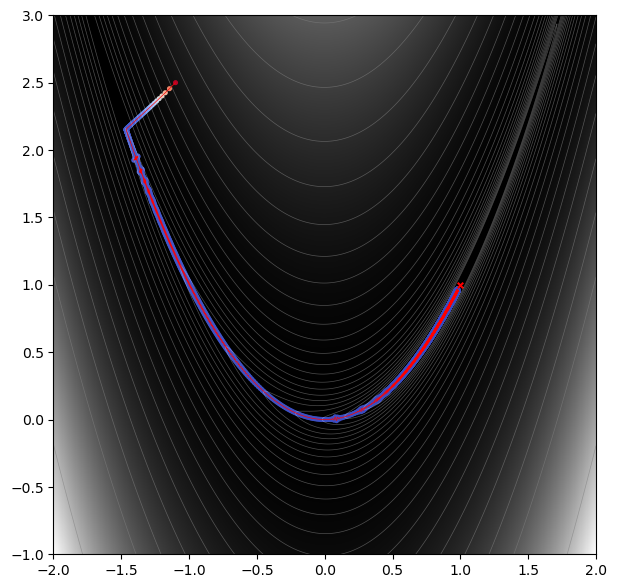

In [3]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.RMSprop(smoothing=0.95, eps=1e-4), tz.m.LR(1e-2))
func.run(optimizer, max_steps=4000)
func.plot(log_contour=True)

### 3.3 Adam
**Adam** is a modification to RMSprop where instead of dividing the gradients, it divides an exponential moving average of gradients, i.e. momentum.

It also applies debiasing to both exponential moving averages, explained below.

At step $k$ (with $k$ starting from 1) the update rule is:
$$
\text{update exponential moving average of gradients:}\\\\
m_t \leftarrow \beta_1 m_{t-1} + (1 - \beta_1) \nabla f(x_t)
$$
$$
\text{update exponential moving average of squared gradients:}\\\\
v_t \leftarrow \beta_2 v_{t-1} + (1 - \beta_2) \nabla f(x_t)^2
$$
$$
\text{compute debiased  exponential moving averages } \hat{m_t} \text{ and } \hat{v_t} \text{:} \\\\
\hat{m}_{t} = m_t / (1 - \beta_1^k)\\\\
\hat{v}_{t} = v_t / (1 - \beta_2^k)\\\\
$$

$$
\text{update parameters:}\\\\
x_{t+1} \leftarrow x_t - \eta \frac{\hat{m}_{t}}{\sqrt{\hat{v}_{t} + \epsilon}}
$$
Here $\beta_1$ controls gradient momentum and $\beta_2$ controls momentum of squared gradients. The defaults are $\beta_1 = 0.9, \beta_2 = 0.999, \epsilon = 10^{-8}$.

The debiasing is useful because exponential moving averages $m_0$ and $v_0$ are initialized with zeros, therefore they are biased towards zero. 

Consider the first step with $\beta_2=0.999$, then exponential moving average of squared gradients is $v_1 = 0.999 \cdot v_0 + 0.001 \cdot \nabla f(x_t)^2 = 0.001 \cdot \nabla f(x_t)^2$. It has very small values, so when we divide by it's square root in $\frac{m_{t}}{\sqrt{v_{t} + \epsilon}}$, the update magnitude becomes way too large for first few steps.

Now with debiasing, the bias-corrected exponential moving average of squared gradients on first step is $\hat{v}_1 = \frac{0.001 \cdot \nabla f(x_t)^2}{0.001} = \nabla f(x_t)^2$. It is no longer 1000 times smaller than it should be, so updates are no longer excessively big.

$m_t$ is debiased for the same purpose, without debiasing it is smaller than it should be.

This is called debiasing because $m_t$ is a biased estimate of the mean of past gradients, and $v_t$ is a biased estimate of variance. And debiasing makes them unbiased.

Reference: *[Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980](https://arxiv.org/abs/1412.6980)*

finished in 0.7s., reached loss = 4.02e-05                                      


<Axes: >

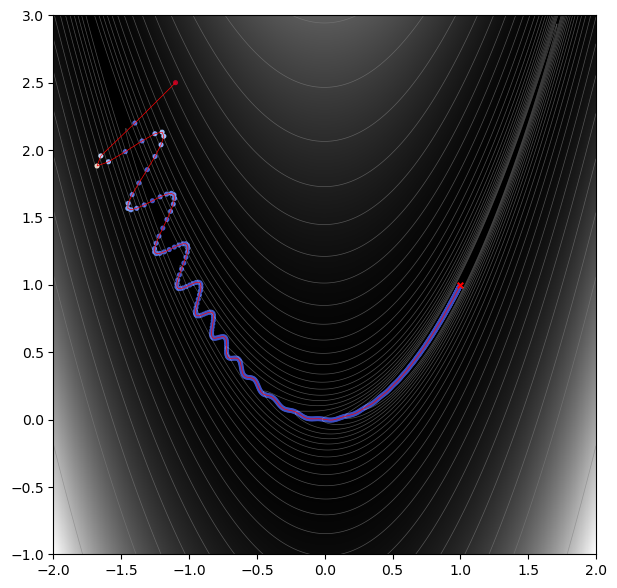

In [4]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.Adam(beta1=0.95, beta2=0.99), tz.m.LR(3e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.4 AdaHessian

**AdaHessian** is very similar to Adam, except squared gradients are replaced by squared randomized estimates of the hessian diagonal.

$$
m_t \leftarrow \beta_1 m_{t-1} + (1 - \beta_1) \nabla f(x_t)
$$
$$
D = diag(\mathbf{H}) = \mathbb{E}[\mathbb{z} \odot \mathbf{H}\mathbf{z}] \approx z \odot Hz
$$
$$
v_t \leftarrow \beta_2 v_{t-1} + (1 - \beta_2) D^2
$$
$$
x_{t+1} \leftarrow x_t - \eta \frac{m_t}{\sqrt{v_t + \epsilon}}
$$
Here $z$ is a random Rademacher vector, and D is approximated as $z \odot Hz$, meaning element-wise multiplication of $z$ and hessian-vector product $Hz$. Most automatic differentiation frameworks such as PyTorch allow computing hessian-vector products without having to compute full hessian, alternatively hessian-vector product can be estimated using finite difference with one extra gradient calculation.

Reference: *[Yao, Zhewei, et al. "Adahessian: An adaptive second order optimizer for machine learning." proceedings of the AAAI conference on artificial intelligence. Vol. 35. No. 12. 2021](https://arxiv.org/abs/2006.00719).*

finished in 4.2s., reached loss = 0.00762                                      


<Axes: >

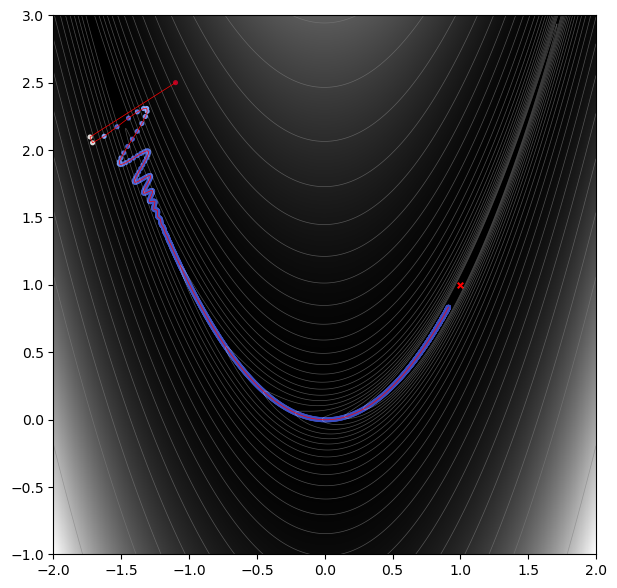

In [5]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.AdaHessian(beta1=0.95, beta2=0.99, seed=4),  tz.m.LR(1))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### 3.5 SophiaG, ESGD
**SophiaG**[1] and **ESGD** (Equilibrated stochastic gradient descent)[2] also use hessian-vector products with random vectors. SophiaG is similar to AdaHessian, but hessian-vector products are with normally distributed random vectors, their products with vectors are not squared, and agressive clipping of the update is used. ESGD is essentially Adagrad with squared gradients replaced by squared hessian-vector products.

[1] *[Liu, Hong, et al. "Sophia: A scalable stochastic second-order optimizer for language model pre-training." arXiv preprint arXiv:2305.14342 (2023).](https://arxiv.org/abs/2305.14342)*

[2] *[Dauphin, Yann, Harm De Vries, and Yoshua Bengio. "Equilibrated adaptive learning rates for non-convex optimization." Advances in neural information processing systems 28 (2015).](https://arxiv.org/abs/1502.04390)*

finished in 2.4s., reached loss = 0.00193                                      


<Axes: >

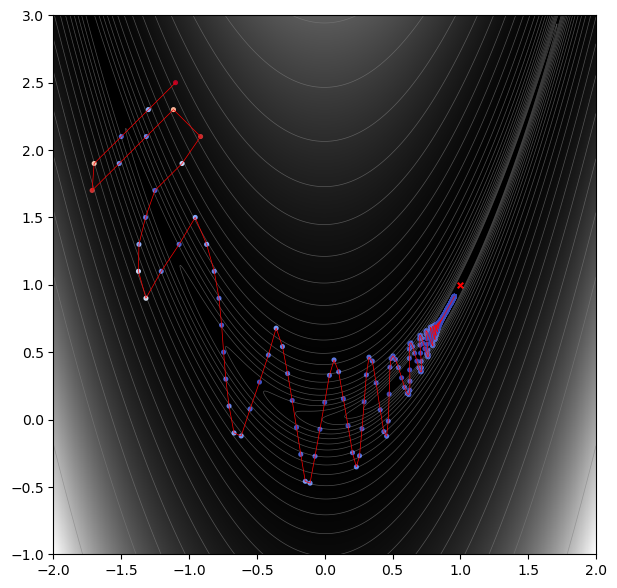

In [6]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.SophiaH(seed=0),  tz.m.LR(2e-1))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### 3.6 Lion
**Lion** (Evo**L**ved S**i**gn M**o**me**n**tum) is a method discovered by an evolutionary search of optimization algorithms. It essentially uses sign of dampened momentum.

$$
d_t = sign(\beta_1 v_{t-1} + (1 - \beta_1) \nabla f(x_t))
$$
$$
v_t \leftarrow \beta_2 v_{t-1} + (1 - \beta_2) \nabla f(x_t)
$$
$$
x_{t+1} \leftarrow x_t - \eta d_t
$$

Reference: *[Chen, Xiangning, et al. "Symbolic discovery of optimization algorithms." Advances in neural information processing systems 36 (2023): 49205-49233.](https://arxiv.org/abs/2302.06675)*

finished in 1.2s., reached loss = 9.61e-10                                      


<Axes: >

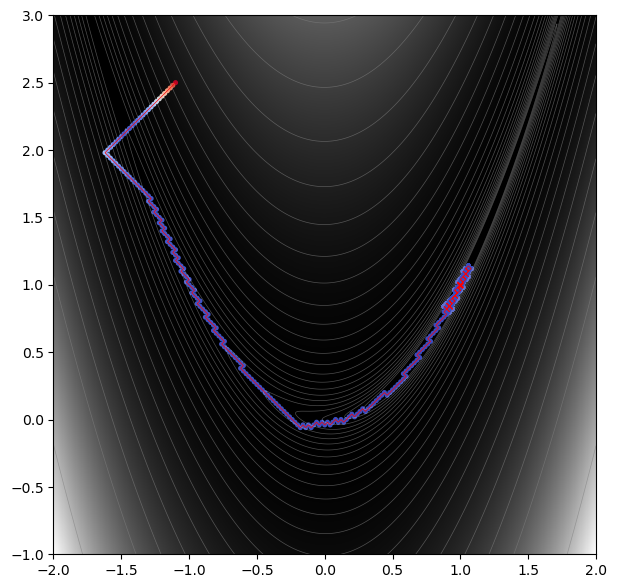

In [7]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.Lion(),  tz.m.LR(2e-2))
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True)

### 3.7 Grams
**Grams** is Adam, except it uses magnitute of Adam's update, and sign of the gradient. Similar modification can be applied to any other momentum-based optimizer.

Reference: *[Cao, Yang, Xiaoyu Li, and Zhao Song. "Grams: Gradient descent with adaptive momentum scaling." arXiv preprint arXiv:2412.17107 (2024).](https://arxiv.org/pdf/2412.17107)*

finished in 0.8s., reached loss = 0.00616                                      


<Axes: >

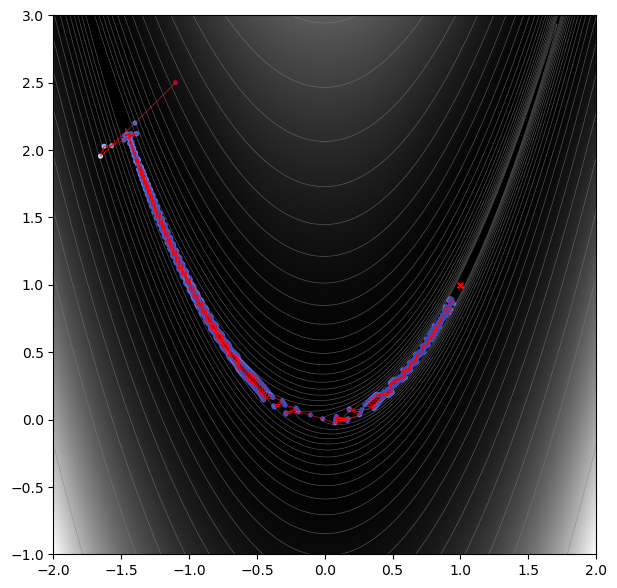

In [8]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Adam(beta1=0.95, beta2=0.95),
    tz.m.GradSign(),
    tz.m.LR(3e-1)
)
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.8 LaProp
**LaProp**, like Adam, is a version of RMSprop with momentum and Adam debiasing. LaProp first divides gradient by the exponential moving average of squared gradients, and then tracks an exponential moving average of that update.

Reference: *[Ziyin, Liu, Zhikang T. Wang, and Masahito Ueda. "LaProp: Separating momentum and adaptivity in Adam." arXiv preprint arXiv:2002.04839 (2020).](https://arxiv.org/abs/2002.04839)*

finished in 1.0s., reached loss = 1.88e-05                                      


<Axes: >

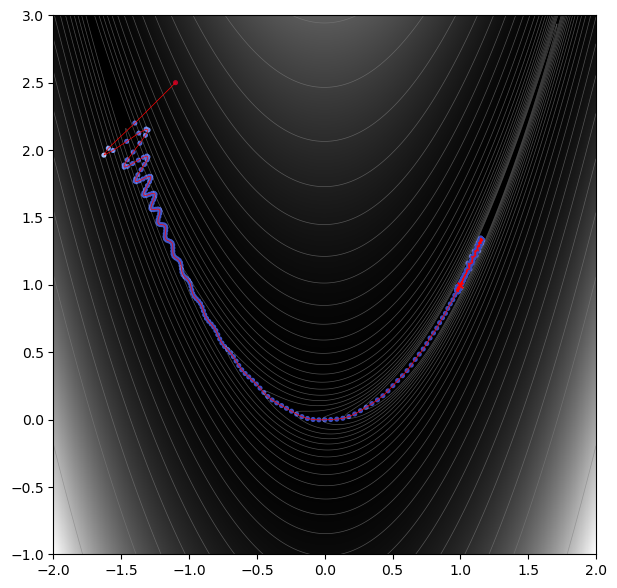

In [9]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.RMSprop(0.95),
    tz.m.Debias(beta1=None, beta2=0.95),
    tz.m.EMA(0.95),
    tz.m.Debias(beta1=0.95, beta2=None),
    tz.m.LR(3e-1)
)
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.9 Adan
**Adan (Adaptive nesterov momentum)**. Adan combines Nesterov's momentum with adaptive per-parameter learning rates and is suggested for large-batch optimization. The update rule is quite long so here is a screenshot from the paper.
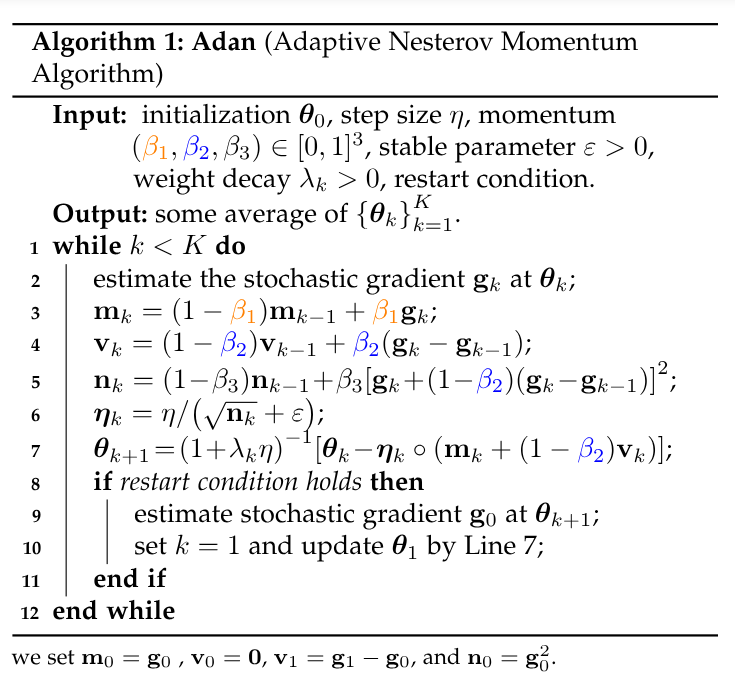

Reference: *[Xie, Xingyu, et al. "Adan: Adaptive nesterov momentum algorithm for faster optimizing deep models." IEEE Transactions on Pattern Analysis and Machine Intelligence 46.12 (2024): 9508-9520.](https://arxiv.org/abs/2208.06677)*

finished in 0.8s., reached loss = 3.32e-07                                      


<Axes: >

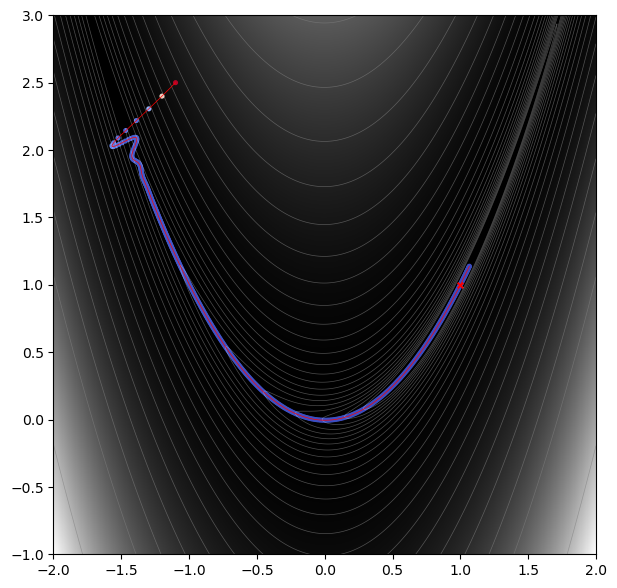

In [10]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.Adan(),  tz.m.LR(1e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.10 MARS
**MARS** (Make vAriance Reduction Shine) is a variance reduction method which can actually be applied to any other optimizer. It calculates a variance-reduced gradient as follows:
$$
c_t = f(x_t, \xi_t) + \gamma * \frac{\beta}{1 - \beta} * (\nabla f(x_t, \xi_t) - \nabla f(x_{t-1}, \xi_t))
$$
$$
\text{if } ||c_t||_2 > 1, \text{then } c_t \rightarrow \frac{c_t}{||c_t||_2}
$$
Here $c_t$ is variance-reduced gradient that can be passed to another optimizer, $\beta$ should be set to the same value as momentum hyperparameter the optimizer, and $\gamma$ is a hyperparameter controlling scale of the correction.

$\nabla f(x_t, \xi_t)$ means gradient at parameters $x_t$ with mini-batch $\xi_t$. If you look at first formula, it also requires $\nabla f(x_{t-1}, \xi_t)$ - gradient at previous parameters $x_{t-1}$ and current mini-batch $\xi_t$. Funny enough, authors suggest to replace $f(x_{t-1}, \xi_t)$ with an approximation $f(x_{t-1}, \xi_{t-1})$ that doesn't require an extra evaluation, and it performs just as well in their experiments despite essentially not doing any variance reduction anymore. Nonetheless whatever MARS correction does appears to consistently speed Adam up.

Reference: *[Yuan, Huizhuo, et al. "Mars: Unleashing the power of variance reduction for training large models." arXiv preprint arXiv:2411.10438 (2024).](https://arxiv.org/abs/2411.10438v1)*

finished in 0.9s., reached loss = 9.95e-07                                      


<Axes: >

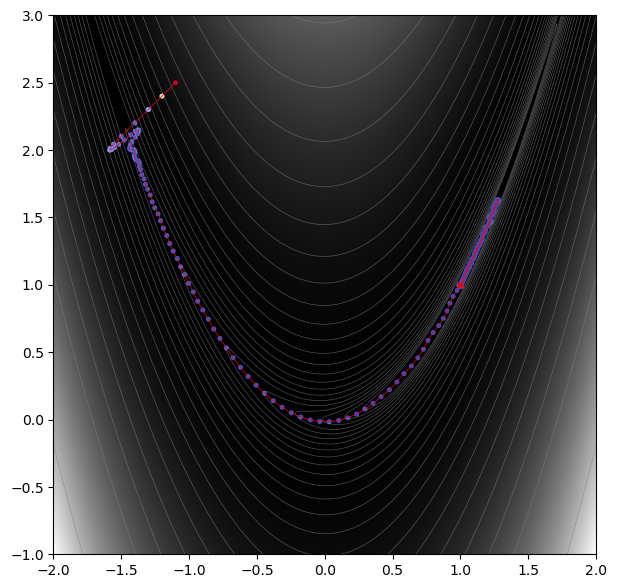

In [11]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.MARSCorrection(beta=0.95), tz.m.Adam(beta1=0.95), tz.m.LR(1e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.11 Rprop
**Rprop** uses only the sign of the gradient. It uses a per-parameter adaptive learning rate - if gradient sign for a weight changed after updating parameters, the learning rate for that weight is reduced and the update for that weight is undone, otherwise the learning rate is increased. Rprop requires essentially no tuning, as the learning rates are adapted automatically.

Because it uses differences in gradients, it is not suitable for stochastic optimization. However it can be a very strong method for non-stochastic tasks, for example in my experiments it outperformed L-BFGS on training PINNs, although SOAP then beat both.

Reference: *[Riedmiller, Martin, and Heinrich Braun. "A direct adaptive method for faster backpropagation learning: The RPROP algorithm." IEEE international conference on neural networks. IEEE, 1993.](https://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Fall.2016/pdfs/Rprop.pdf)*

finished in 3.3s., reached loss = 0.0141                                      


<Axes: >

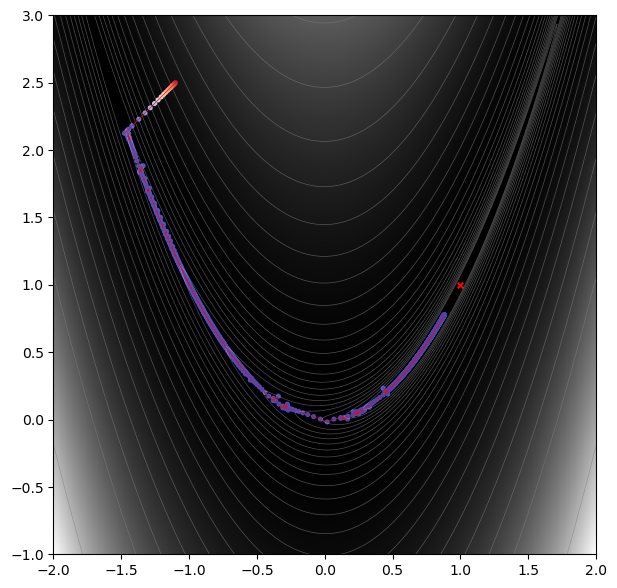

In [12]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(func.parameters(), tz.m.Rprop(), tz.m.LR(1e-3))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### 3.12 Full-matrix Adagrad

The full-matrix version of **Adagrad** uses the following update rule:
$$
G_t \leftarrow G_{t-1} + \nabla f(x_t) \nabla f(x_t)^T
$$
$$
x_{t+1} \leftarrow x_t - G_t^{-1/2}\nabla f(x)
$$

On each step it adds outer product of the gradient with itself to the accumulator $G$, and calculates the update as inverse square root of $G$ times gradient. 

What that does is similar ZCA whitening. If we consider a dataset of all past gradients, accumulator $G$ is an approximation to the covariance matrix of that dataset. ZCA whitening would center the dataset and multiply it by $G^{-1/2}$, which makes covariance matrix of the new transformed dataset identity. Full matrix Adagrad is the same except it doesn't center.

In order to demonstrate the power of full-matrix Adagrad we will use the rotated quadratic function, defined as
$$
f(x,y) = x^2 + y^2 + 1.99 * x * y
$$

This is a very hard function, and because it is rotated (i.e. large off-diagonal hessian elements), diagonal methods take a large number of steps to converge (even Adam). Full-matrix Adagrad, however, takes a straight path towards the minima, minimizing the function in less steps.

finished in 1.1s., reached loss = 0.0196                                      
finished in 0.1s., reached loss = 1.82e-05                                      


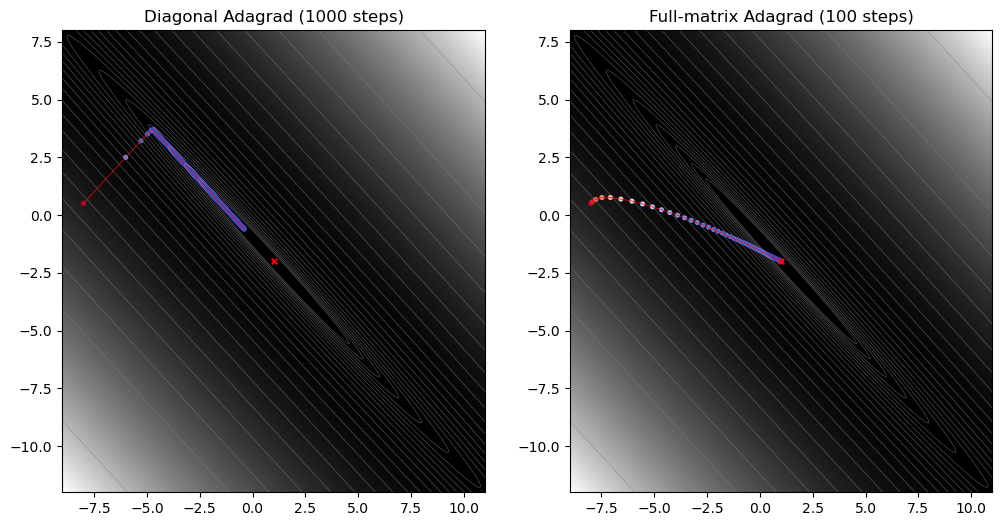

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# diagonal Adagrad
func = FunctionDescent('ill2')
optimizer = tz.Optimizer(func.parameters(), tz.m.Adagrad(), tz.m.LR(2))
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Diagonal Adagrad (1000 steps)")

# full-matrix Adagrad
func = FunctionDescent('ill2')
optimizer = tz.Optimizer(func.parameters(), tz.m.FullMatrixAdagrad(init='zeros', reg=1e-4), tz.m.WarmupNormClip(10), tz.m.LR(1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Full-matrix Adagrad (100 steps)")

plt.show()

### 3.13 Full-matrix Adam
In torchzero `FullMatrixAdagrad` is flexible and allows to define a full-matrix version of many other algorithms. Recall that Adam applies preconditioning to momentum, and uses exponential moving average instead of sum. In torchzero many algorithms that implement preconditioning have an `inner` argument, which accepts modules that the preconditioning will be applied to instead of the gradient, and we can put `tz.m.EMA` in it.

Since we are using Adam, we can up the difficulty of the function by making it even more stretched:
$$
f(x,y) = x^2 + y^2 + 1.999 * x * y
$$


finished in 0.7s., reached loss = 3.52e-05                                      
finished in 0.2s., reached loss = 2.91e-06                                      


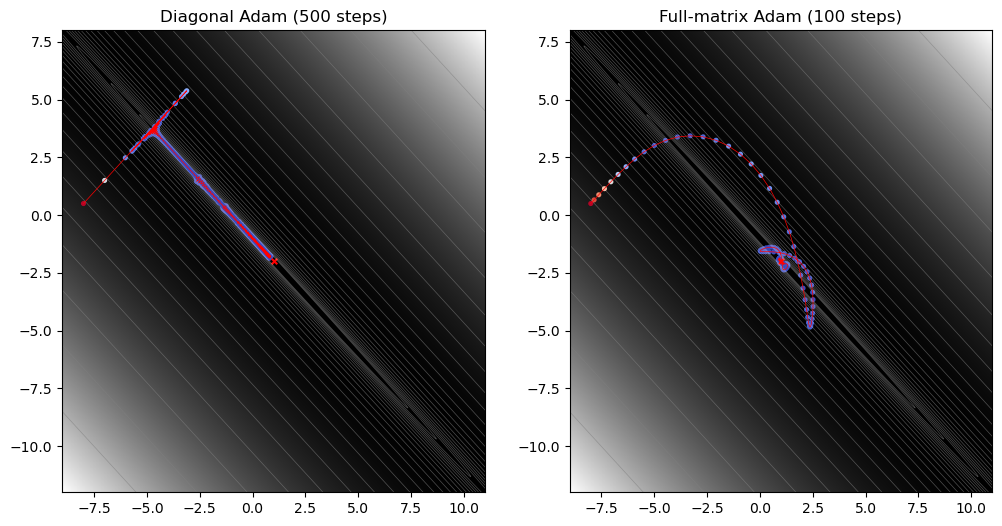

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# diagonal Adam
func = FunctionDescent('ill3')
optimizer = tz.Optimizer(func.parameters(), tz.m.Adam(0.9, 0.95), tz.m.LR(1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Diagonal Adam (500 steps)")

# full-matrix Adam
func = FunctionDescent('ill3')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.FullMatrixAdagrad(init='zeros', reg=1e-5, beta=0.95, inner=tz.m.EMA(0.9)),
    tz.m.Debias(0.9, 0.95),
    tz.m.LR(1)
)
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Full-matrix Adam (100 steps)")

plt.show()

### 3.14 Shampoo
Big drawback of Full-matrix Adagrad is that it requires storing a large $n \times n$ matrix and calculating its inverse square root, so it is really only feasible under around 5,000 parameters. Various methods exist that approximate G, for example Shampoo, SM3.

Shampoo utilizes the tensor structure of the parameters - for a $H \times W$ parameter it preconditions each row and each column separately, leading to $H^2 + W^2$ space. For example, a $100 \times 100$ parameter would require $100,000^2$ storage with full-matrix Adagrad, and $200,000$ with Shampoo.

Shampoo update for a matrix parameter $X_t$ is as follows:
$$
G_t = \nabla f(X_t) \\\\
L_t \leftarrow L_{t-1} + GG^T \\\\
R_t \leftarrow R_{t-1} + G^TG \\\\
X_{t+1} \leftarrow X_t - \eta L_t^{-1/4} G_t R_t^{-1/4}
$$

Shampoo is also defined in a similar way for tensor parameters (with dimension larger than 2). I don't know why uses $1/4$ instead of $1/2$, but there must be some good reason, although replacing it with $1/2$ has been suggested on some follow up papers too.

Shampoo is available in torchzero as `tz.m.Shampoo`. Similarly to `tz.m.FullMatrixAdagrad`, it is flexible and allows defining Shampoo-versions of various algorithms.

On a two-dimensional function Shampoo is equivalent to full-matrix Adagrad, so we can't really visualize it.

Reference: *[Gupta, Vineet, Tomer Koren, and Yoram Singer. "Shampoo: Preconditioned stochastic tensor optimization." International Conference on Machine Learning. PMLR, 2018.](https://arxiv.org/abs/1802.09568)*
___

### 3.15 Limited-memory Adagrad

**Limited-memory Adagrad** stores a history of past $n$ gradients and computes an update equivalent to full-matrix Adagrad on those past $n$ gradients.

There update rule:

1. take past $k$ gradient vectors and stack them as columns into a single matrix $G\in \mathbb{R}^{d\times k}$, where $d$ is dimensionality of the problem.
2. calculate $M = G^TG$, which is a ${k\times k}$ matrix.
3. add damping to $M$:
    $$
    M = N + I * \lambda
    $$
    Here $\lambda$ is the damping hyperparameter, can be some small value like 1e-6.
4. Calculate eigendecomposition of $M$
    $$
    QΛQ^T =\text{eigh}(M)
    $$
5. Compute U
    $$
    U = GQ\sqrt{Λ}
    $$
6. So now we have $U$ and $\Sigma$ from SVD(G), but computed more efficiently. We want to compute $(GG^T)^{-1/2}$, which can be expressed through SVD of $G$:
    $$
    GG^T = (U \Sigma V^T)(U \Sigma V^T)^T = U \Sigma V^T V \Sigma^T U^T = U \Sigma^2 U^T \\\\
    (GG^T)^{-1/2} = (U \Sigma^2 U^T)^{-1/2} = U (\Sigma^2)^{-1/2} U^T = U \Sigma^{-1} U^T
    $$
    therefore the update rule is
    $$
    x_{t+1} \leftarrow x_t - \eta U_t Λ_t^{-1/2} U_t^T \nabla f(x_t)
    $$

Reference: *[Agarwal N. et al. Efficient full-matrix adaptive regularization //International Conference on Machine Learning. – PMLR, 2019. – С. 102-110.](https://arxiv.org/abs/1806.02958)*

finished in 0.3s., reached loss = 6.27e-10                                      


<Axes: >

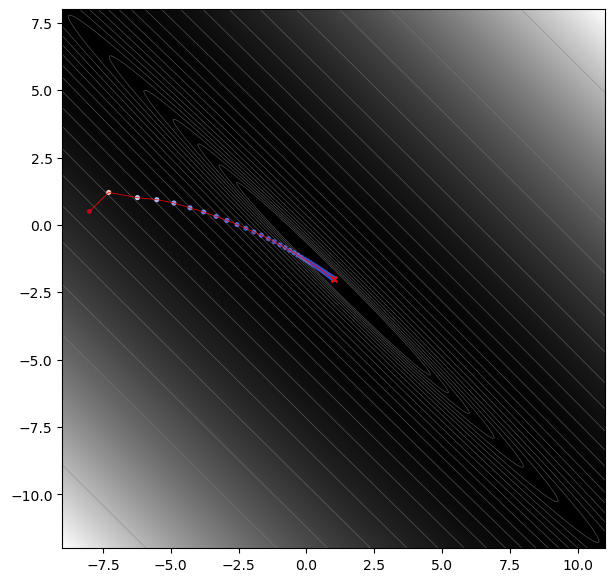

In [15]:
func = FunctionDescent('ill2')
optimizer = tz.Optimizer(func.parameters(), tz.m.LMAdagrad(damping=0), tz.m.LR(1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True)

### 3.16 Muon
**Muon** (MomentUm Orthogonalized by Newton-Schulz) is an optimization algorithm made specifically for matrix parameters - ones that are involved in matrix multiplications. In a typical neural network a linear layer, a convolutional layer, and Q, K and V in a transformer layer are examples of such parameters.

Muon approximately orthogonalizes the update for those parameters using an efficient Newton-Schulz iteration. The motivation behind this can be found in author's blogpost - https://kellerjordan.github.io/posts/muon/. In Muon orthogonalization is applied to nesterov's momentum, and non-matrix parameters are optimized using some other optimizer, for example Adam. Muon (ignoring momentum) is also equivalent to memoryless Shampoo where the accumulators are reset after each step.

Since Muon only works on matrices, we can't easily visualize it on our 2D function, so I will just give an example of how Muon is constructed.

Authors suggest that embeddings, classifier heads, hidden gains/biases and first convolutional layer should be optimized using standard AdamW. Embeddings are not involved in matrix multiplications, while the other recommendations are empirical.

In torchzero orthogonalization with a Newton-Schulz solver is implemented as ``Orthogonalize`` module. Parameters can be split by using the ``Split`` module based on a filter. The filter can either be a callable, a parameter itself, or a list of filters.

For example to select 2D+ parameters to optimize with Muon we can do this:
```python
filter = lambda x: x.ndim >= 2
```
or to be more specific, pass an iterable of specific tensors for Muon:
```python
filter = (model.c2.weight, model.c3.weight)
```

In [16]:
class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2, 2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(32*9, 10))

    def forward(self, x):
        x = F.elu(self.c1(x), inplace=True)
        x = F.elu(self.c2(x), inplace=True)
        x = F.elu(self.c3(x), inplace=True)
        return self.head(x)

model = TinyConvNet().cuda()

optimizer = tz.Optimizer(
    model.parameters(),
    # same hyperparams as https://github.com/KellerJordan/Muon
    tz.m.NAG(0.95),
    tz.m.Split(
        filter = (model.c2.weight, model.c3.weight),
        # or `filter = lambda x: x.ndim >= 2` to select all 2D+ params.
        true = tz.m.Orthogonalize(),
        false = [tz.m.Adam(0.9, 0.95), tz.m.Mul(1/66)],
    ),
    tz.m.LR(1e-2),
)

### 3.17 SOAP

**SOAP** (ShampoO with Adam in the Preconditioner’s eigenbasis) runs Adam in the eigenbasis of Shampoo’s preconditioner. SOAP is more stable, computationally efficient and convergent than Shampoo. The update rule is quite long so here is a screenshot from the paper.

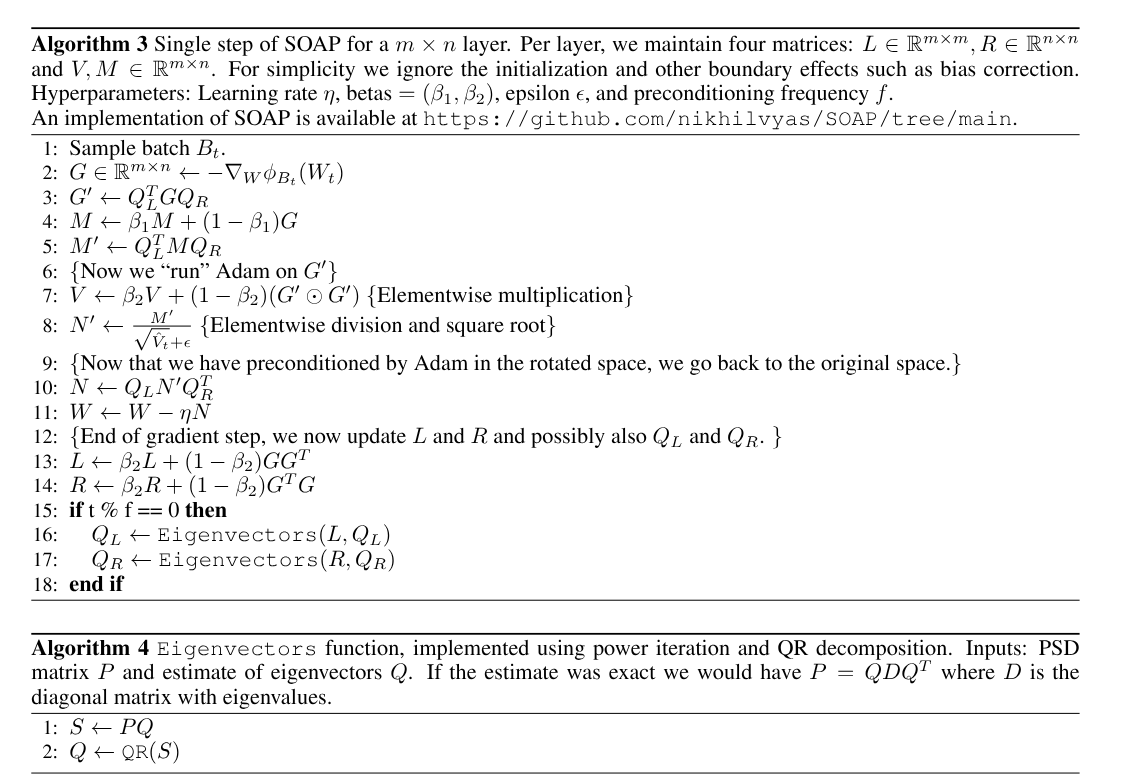

SOAP projects gradients to Shampoo's eigenbasis where $\mathbb{E}(\nabla f(x_t) \nabla f(x_t)^T)$ approximates a diagonal matrix, i.e. gradients for each weight are decorellated. It then applies Adam's update rule to projected gradients. Since projected gradients have approximately diagonal covariance matrix, Adam's diagonal preconditioning captures most of the variance and sets it to 1. Gradients are then un-projected which should give approximately identity covariance matrix.

It is able to minimize even the most extreme version of the rotated quadratic function in few steps:

$$
f(x,y) = x^2 + y^2 + 1.999999 * x * y
$$

No other adaptive method is able to minimize this, even quasi-newton methods tend to fail due to extremely large condition number of the hessian.

Reference: *[Vyas, Nikhil, et al. "SOAP: Improving and Stabilizing Shampoo using Adam." arXiv preprint arXiv:2409.11321 (2024).](https://arxiv.org/abs/2409.11321)*

finished in 0.4s., reached loss = 5.07e-07                                      


<Axes: >

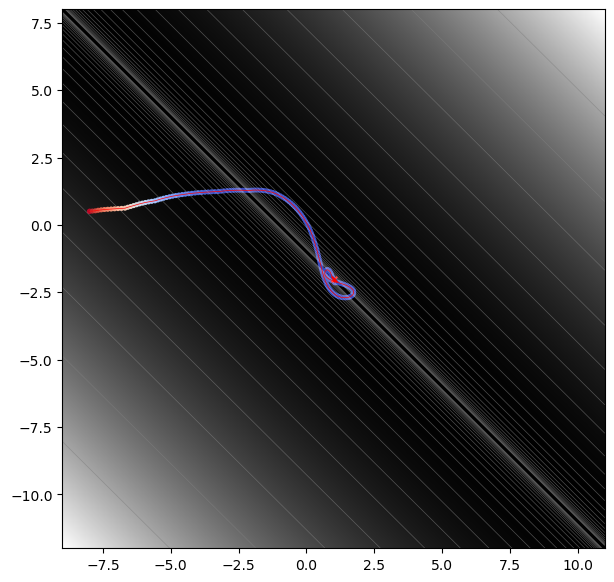

In [17]:
func = FunctionDescent('ill6')
optimizer = tz.Optimizer(func.parameters(), tz.m.SOAP(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=200)
func.plot(log_contour=True)

### 3.18 Natural gradient
Natural gradient uses Fisher information matrix (FIM) as the preconditioner, and once I manage to understand what FIM does, I will promptly attempt to explain it here.

Typically we don't have access to FIM. However an approximation exists when we are training a model on a batch of samples, called empirical fisher information matrix (EFIM).

Given $k$ samples, we calculate $k$ per-sample gradients and stack them into a matrix $G\in \mathbb{R}^{d\times k}$.

Then empirical fisher is calculated as $F = GG^T$.

The update is then calculated as:
$$
x_{t+1} \leftarrow x_t - \eta F_t^{-1}\nabla f(x_t)
$$

You might recognize that this is very similar to full-matrix Adagrad, except for some reason it doesn't have a square root.

In practice since $F=GG^T$ is a low rank matrix so we don't need to explicitly form it, torchzero implements a more efficient way to calculate $F^{-1}\nabla f(x)$ and thus doesn't use $N^2$ memory.

Since natural gradient requires training on samples, we can't really visualize it on a 2D function. Instead here is a basic training example.

We pass `loss=losses` to `opt.step`, and it takes care of calculating a batch of gradients. The gradients are calculated in batched mode.

In [18]:
X = torch.randn(64, 20)
y = torch.randn(64, 10)

model = nn.Sequential(nn.Linear(20, 64), nn.ELU(), nn.Linear(64, 10))
opt = tz.Optimizer(
    model.parameters(),
    tz.m.NaturalGradient(),
    tz.m.LR(3e-2)
)

for i in range(100):
    y_hat = model(X) # (64, 10)
    losses = (y_hat - y).pow(2).mean(0) # (10, )
    opt.step(loss=losses)
    if i % 10 == 0:
        print(f'{losses.mean() = }')

losses.mean() = tensor(1.1702, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.8838, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.6578, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.4738, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.3156, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.2008, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.1394, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.0933, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.0734, grad_fn=<MeanBackward0>)
losses.mean() = tensor(0.0644, grad_fn=<MeanBackward0>)


### 3.19 Combinations
If one desires, one can create an abomination by chaining various optimizers together, although the practicality of such approach is questionable.

finished in 1.6s., reached loss = 1.31e-07                                      


<Axes: >

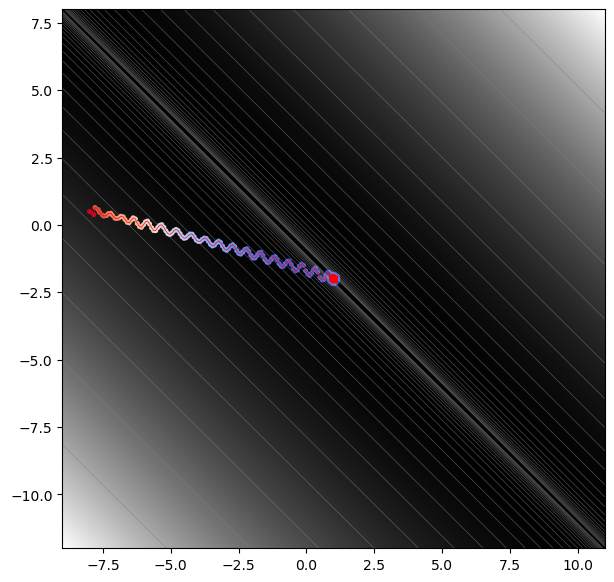

In [19]:
func = FunctionDescent('ill4')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.experimental.FFTProjection(
        [tz.m.MARSCorrection(), tz.m.Adan(0.7), tz.m.SOAP(0.3),  tz.m.NAG(-0.9), tz.m.LR(2e-1)]
    )
)
func.run(optimizer, max_steps=500)
func.plot(log_contour=True)

### 3.20 What should I use?

I can suggest a very strong baseline:

```python
opt = tz.Optimizer(
    model.parameters(),
    tz.m.SOAP(),
    tz.m.ClipNormByEMA(max_ema_growth=1.2),
    tz.m.RelativeWeightDecay(1e-2),
    tz.m.LR(lr).
)
```

Muon can also have very good performance on some models, and it is much cheaper to compute than SOAP.

Another strong baseline is PSGD Kron, although it has not yet been implemented in torchzero.